<a href="https://colab.research.google.com/github/tkassahu/clinical-trial-attrition-prediction/blob/main/Attrition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/Final_Clean_ClinicalTrials.csv'  # Update path as needed
df = pd.read_csv(file_path)

# Check the first few rows
print(df.head())


        nct_id  dropout_percentage_all  duration  locations  condition_count  \
0  NCT00001596                   17.39    3903.0          1                5   
1  NCT00001723                    8.00    4901.0          1                5   
2  NCT00003869                   21.88    3318.0          1                3   
3  NCT00003901                    0.86    4475.0         58                1   
4  NCT00045162                   24.44    2587.0        408                1   

   armGroupsCount  enrollmentInfo  healthyVolunteers  seriousEvents  \
0               2              35                  0              5   
1               2             200                  0              2   
2               2             186                  0             29   
3               1            1310                  0              0   
4               2             671                  0             89   

   participant_masked  ...  PHASE3  PHASE4  multiple_interventions  DRUG  \
0               

In [ ]:
# Define target variable
y = df['dropout_percentage_all']

# Select features
X = df.drop(columns=['nct_id', 'dropout_percentage_all'])

#Check for missing values and handle them
print(df.isna().sum())

# Fill missing values (if any) with median values
X.fillna(X.median(), inplace=True)


nct_id                    0
dropout_percentage_all    0
duration                  0
locations                 0
condition_count           0
armGroupsCount            0
enrollmentInfo            0
healthyVolunteers         0
seriousEvents             0
participant_masked        0
CHILD                     0
ADULT                     0
OLDER_ADULT               0
PHASE1                    0
PHASE2                    0
PHASE3                    0
PHASE4                    0
multiple_interventions    0
DRUG                      0
BIOLOGICAL                0
DEVICE                    0
RADIATION                 0
FEMALE                    0
MALE                      0
ALL_SEX                   0
dtype: int64


In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data (if required, based on the model)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R² Score: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


R² Score: 0.31270315613532684
MSE: 77.35016063237734
RMSE: 8.794894009161073


                   Feature  Importance
0                 duration    0.310335
6            seriousEvents    0.194566
4           enrollmentInfo    0.150729
1                locations    0.121566
2          condition_count    0.057359
3           armGroupsCount    0.040653
5        healthyVolunteers    0.027726
16                    DRUG    0.017779
7       participant_masked    0.015011
12                  PHASE2    0.014300
8                    CHILD    0.012417
13                  PHASE3    0.011305
14                  PHASE4    0.010023
15  multiple_interventions    0.006479
9                    ADULT    0.005155
11                  PHASE1    0.002294
20                  FEMALE    0.000861
22                 ALL_SEX    0.000683
17              BIOLOGICAL    0.000401
18                  DEVICE    0.000303
19               RADIATION    0.000037
21                    MALE    0.000019
10             OLDER_ADULT    0.000000


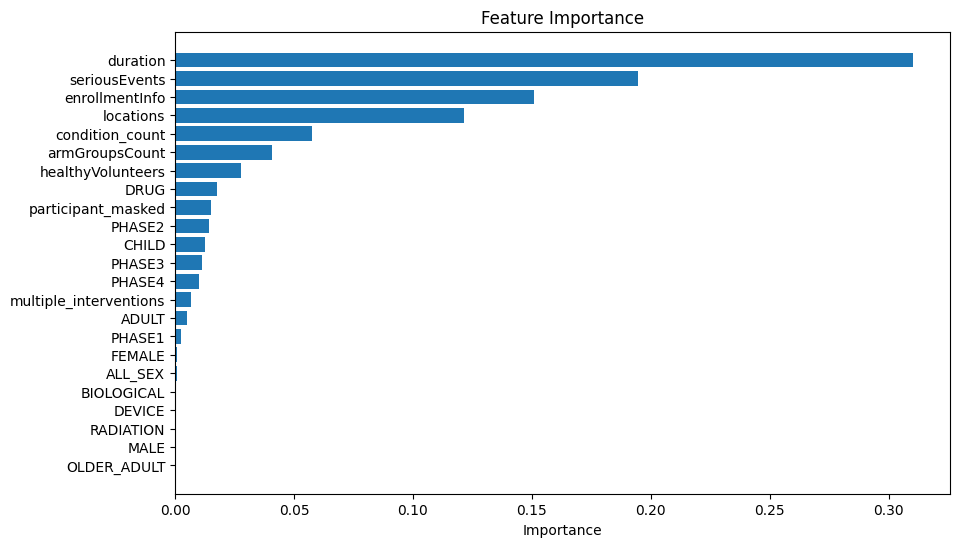

<Figure size 640x480 with 0 Axes>

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

#Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()
# Save the plot as an image file
plt.savefig('Random_forest_feature_importance.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

In [ ]:
import joblib

# Save the model
joblib.dump(model, 'clinical_trials_attrition_model.pkl')

# Save predictions
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.to_csv('attrition_predictions.csv', index=False)

print("Model and predictions saved!")


Model and predictions saved!


In [ ]:
pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare the data
X = df.drop(columns=["dropout_percentage_all", "nct_id"])  # Features
y = df["dropout_percentage_all"]  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to DMatrix format (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for the XGBoost model
params = {
    "objective": "reg:squarederror",  # For regression tasks
    "max_depth": 6,                   # Maximum depth of a tree
    "eta": 0.1,                       # Learning rate
    "subsample": 0.8,                 # Subsample ratio of the training set
    "colsample_bytree": 0.8,          # Subsample ratio of columns when constructing trees
    "eval_metric": "rmse"             # Evaluation metric
}

# Train the XGBoost model
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,               # Number of boosting rounds
    evals=[(dtrain, "train"), (dtest, "test")],  # Evaluation on train and test sets
    early_stopping_rounds=10           # Stop early if no improvement
)

# Predict on the test set
y_pred = xgb_model.predict(dtest)

# Evaluate the model
xgb_r2 = r2_score(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)

print("XGBoost Results:")
print(f"R² Score: {xgb_r2}")
print(f"MSE: {xgb_mse}")
print(f"RMSE: {xgb_rmse}")


[0]	train-rmse:9.80659	test-rmse:10.29679
[1]	train-rmse:9.49153	test-rmse:10.05710
[2]	train-rmse:9.22767	test-rmse:9.88704
[3]	train-rmse:8.98393	test-rmse:9.70101
[4]	train-rmse:8.76342	test-rmse:9.55897
[5]	train-rmse:8.57986	test-rmse:9.42766
[6]	train-rmse:8.40639	test-rmse:9.32222
[7]	train-rmse:8.24950	test-rmse:9.19428
[8]	train-rmse:8.13548	test-rmse:9.13788
[9]	train-rmse:8.00527	test-rmse:9.09323
[10]	train-rmse:7.88822	test-rmse:9.04976
[11]	train-rmse:7.79663	test-rmse:9.00967
[12]	train-rmse:7.67350	test-rmse:8.94725
[13]	train-rmse:7.60623	test-rmse:8.90625
[14]	train-rmse:7.50548	test-rmse:8.87937
[15]	train-rmse:7.42957	test-rmse:8.87276
[16]	train-rmse:7.34606	test-rmse:8.83504
[17]	train-rmse:7.21705	test-rmse:8.79951
[18]	train-rmse:7.12071	test-rmse:8.78360
[19]	train-rmse:6.99466	test-rmse:8.77734
[20]	train-rmse:6.90371	test-rmse:8.75923
[21]	train-rmse:6.78952	test-rmse:8.73749
[22]	train-rmse:6.72293	test-rmse:8.74076
[23]	train-rmse:6.67629	test-rmse:8.72558


In [ ]:
# Get feature importance
importance = xgb_model.get_score(importance_type="weight")
importance_df = pd.DataFrame({
    "Feature": importance.keys(),
    "Importance": importance.values()
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
print(importance_df)



Feature Importance:
                   Feature  Importance
0                 duration       458.0
1                locations       334.0
4           enrollmentInfo       301.0
6            seriousEvents       299.0
3           armGroupsCount       135.0
2          condition_count       105.0
5        healthyVolunteers        45.0
8                    CHILD        35.0
11                  PHASE2        32.0
13                  PHASE4        31.0
7       participant_masked        29.0
15                    DRUG        29.0
12                  PHASE3        23.0
9                    ADULT        20.0
14  multiple_interventions        15.0
17                  DEVICE         6.0
18                  FEMALE         6.0
10                  PHASE1         6.0
16              BIOLOGICAL         5.0
19                 ALL_SEX         1.0


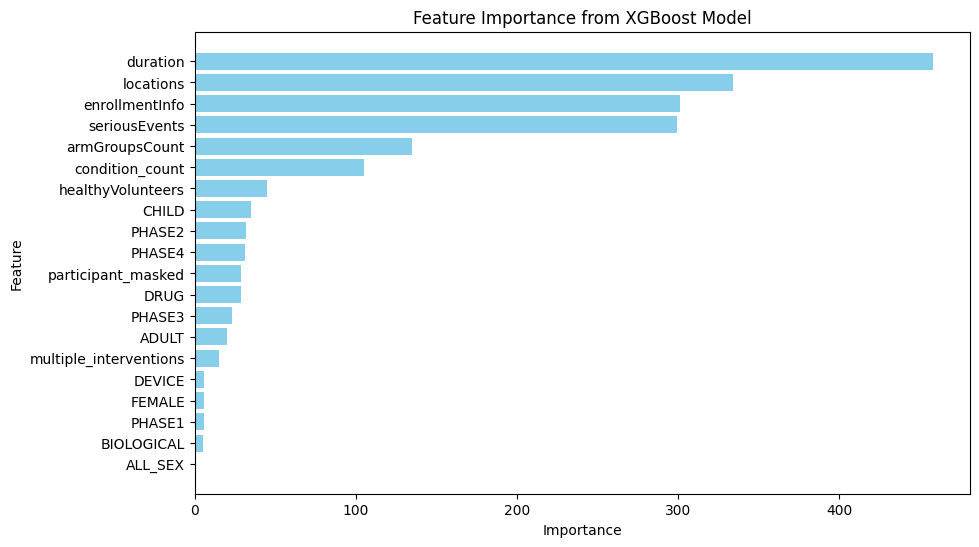

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
importance = xgb_model.get_score(importance_type="weight")
importance_df = pd.DataFrame({
    "Feature": importance.keys(),
    "Importance": importance.values()
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.title("Feature Importance from XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Save the plot as an image file before showing it
plt.savefig('xgb_feature_importance.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

In [ ]:
# Create a comparison table
data = {
    "Model": ["Random Forest", "XGBoost"],
    "R² Score": [0.31271895960081253, 0.3318753148230795],
    "MSE": [77.34838206958489, 75.1924764128073],
    "RMSE": [8.794792895207078, 8.671359548122041]
}

comparison_df = pd.DataFrame(data)

# Display the comparison table directly in the console
print("Comparison Table:")
print(comparison_df)

# Save the comparison table to a CSV file
comparison_df.to_csv("model_comparison.csv", index=False)

print("Comparison table saved as 'model_comparison.csv'.")

Comparison Table:
           Model  R² Score        MSE      RMSE
0  Random Forest  0.312719  77.348382  8.794793
1        XGBoost  0.331875  75.192476  8.671360
Comparison table saved as 'model_comparison.csv'.
